In [65]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)

from src.data import helper
from src.data.cityscapeDataset import CityscapeDataset
from src.data.cityscapeConfig import CityscapeConfig


import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# modeli import
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model as modellib
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import utils

In [66]:
# create new training configurations
config = CityscapeConfig()

dataset = CityscapeDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CityscapeDataset()
val_set.load_dataset(DATA_DIR,'val')
val_set.prepare()

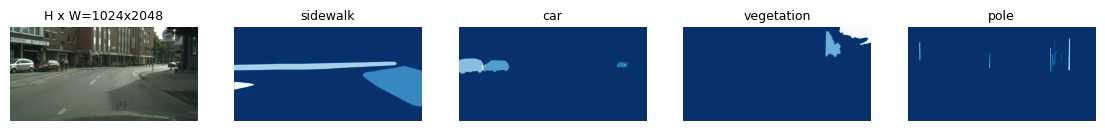

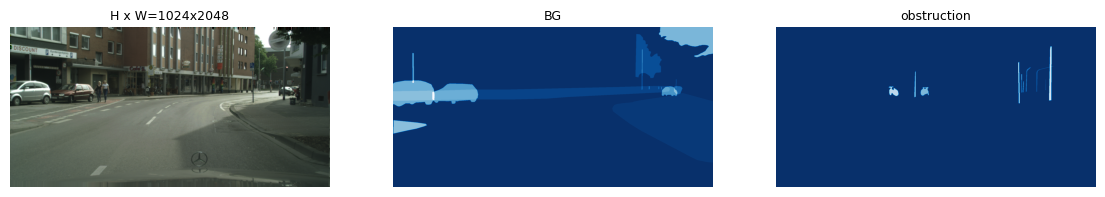

In [64]:
id = random.choice(dataset.image_ids)
print(id)
img = dataset.load_image(id)
masks,labels,obs = dataset.load_mask(id)
names = dataset.class_from_source_map

visualize.display_top_masks(img,
                            masks,
                            labels,
                            names,
                            limit=4)


visualize.display_top_masks(img,
                            masks,
                            obs,
                            {0:'BG',1:'obstruction'},
                            limit=2)

In [3]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
tf.keras.backend.clear_session()
# define a directory to store the tf logs and weights
temp_log = os.path.join(ROOT_DIR,'data/external')
# define existing weights
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')


# construct the model with custom configuration
model = modellib.MaskRCNN(mode='training',
                            config=config, 
                            model_dir=temp_log)

model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# train the model
model.train(dataset, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads',
        )

# Inference

In [76]:
# model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_sidewalks_0001.h5')
try:
  model_path = model.find_last()
except:
  model_path = '//Users/csea/Desktop/deep-learning-final-project-project-sidewalk/models/maskrcnn/logs/3_BCE/mask_rcnn_sidewalks_0010.h5'
print(f'Found model at {model_path}')
class InferenceConfig(CityscapeConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5

inference_config = InferenceConfig()
temp_log = os.path.join(ROOT_DIR,'data/external')

tf.keras.backend.clear_session()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)
# model.load_weights(model_path, by_name=True, )
tf.keras.Model.load_weights(model.keras_model, model_path, by_name=True)


Found model at //Users/csea/Desktop/deep-learning-final-project-project-sidewalk/models/maskrcnn/logs/3_BCE/mask_rcnn_sidewalks_0010.h5


2023-05-17 20:48:45.312265: W tensorflow/c/c_api.cc:300] Operation '{name:'mrcnn_mask_conv4/bias/Assign' id:7245 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask_conv4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask_conv4/bias, mrcnn_mask_conv4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [77]:
# # prepare test dataset
# dataset = CustomDataset()
# dataset.load_dataset(DATA_DIR,'test')
# dataset.prepare()

1505
Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-17 20:48:49.691159: W tensorflow/c/c_api.cc:300] Operation '{name:'mrcnn_detection/Reshape_1' id:6869 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection/packed, mrcnn_detection/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-17 20:48:50.088208: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type

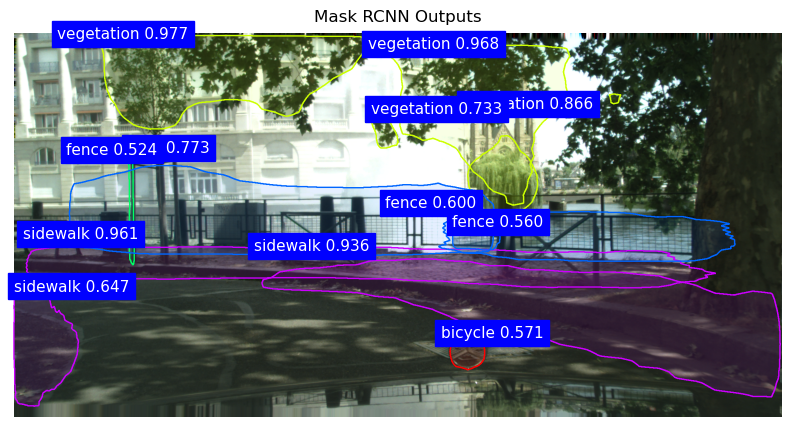

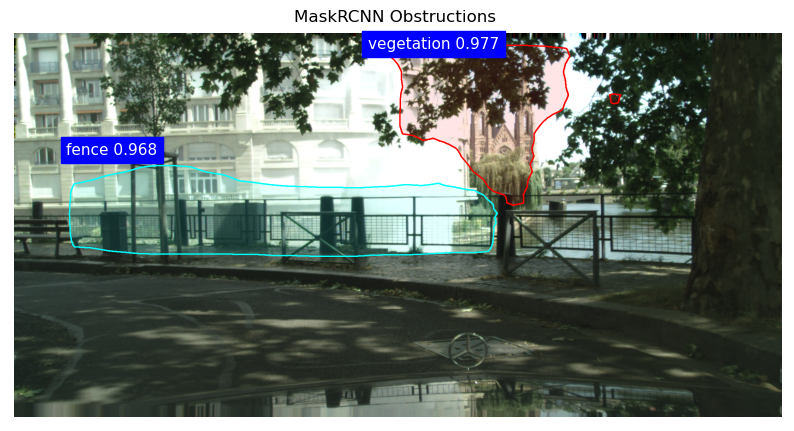

In [78]:
ids = random.choice(dataset.image_ids)
print(ids)
# ids = 297
image = dataset.load_image(ids)
results = model.detect([image],verbose=1)
# display preferences
def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

# captions = helper.generate_captions_obstructed(r['class_ids'], r['obstructions'],labels_dict = val_set.rev_mapping)


r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           list(dataset.class_from_source_map.values()), r['scores'], 
                           ax=get_ax(), title='Mask RCNN Outputs', show_bbox=False)


idx = helper.get_obstruction_idx(r['obstructions'], THRES=0.1)

b,m,l = helper.filter_obstructions(idx, r['rois'], r['masks'], r['class_ids'])
visualize.display_instances(image, b,m,l, 
                           list(dataset.class_from_source_map.values()), r['scores'], 
                           ax=get_ax(),title='MaskRCNN Obstructions ', show_bbox=False)
                           

In [79]:
# image = dataset.load_image(ids)
gt_mask, gt_class_ids, gt_obs = dataset.load_mask(ids)
gt_bbox = utils.extract_bboxes(gt_mask)

ious = helper.generate_ious(gt_class_ids, gt_mask,1)
captions = helper.generate_captions_obstructed(gt_class_ids,
                                             ious,
                                             labels_dict = val_set.rev_mapping)
_ = helper.get_obstruction_idx(captions)

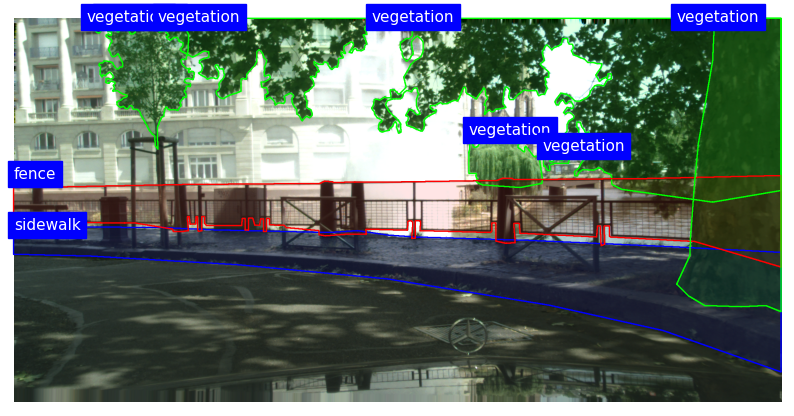

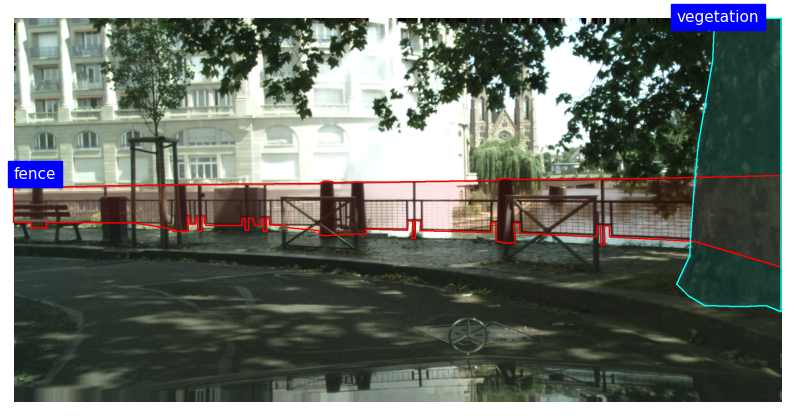

In [80]:
visualize.display_instances(image, gt_bbox,gt_mask, gt_class_ids, 
                            list(dataset.class_from_source_map.values()), ax=get_ax(), 
                            show_bbox=False)

gt_bbox_filtered,gt_mask_filtered,gt_class_ids_filtered = helper.filter_obstructions(_, gt_bbox,gt_mask,gt_class_ids)
visualize.display_instances(image, gt_bbox_filtered,gt_mask_filtered, gt_class_ids_filtered,
                            list(dataset.class_from_source_map.values()), 
                            ax=get_ax(), show_bbox=False)

# Evaluation